In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from transformers import pipeline
import matplotlib.pyplot as plt


In [ ]:
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

In [5]:
df = pd.read_csv("data/ratings_reviews_unique.csv")

In [13]:
df

,userId,movieId,rating,review_text,review_raw_rating,rating_diff
0,1,17,4.0,NaN,NaN,NaN
1,1,25,1.0,NaN,NaN,NaN
2,1,29,2.0,NaN,NaN,NaN
3,1,30,5.0,NaN,NaN,NaN
4,1,32,5.0,NaN,NaN,NaN
...,...,...,...,...,...,...
32000199,200948,79702,4.5,NaN,NaN,NaN
32000200,200948,79796,1.0,NaN,NaN,NaN
32000201,200948,80350,0.5,NaN,NaN,NaN
32000202,200948,80463,3.5,NaN,NaN,NaN


In [ ]:
df_has_reviews = df[df["review_text"].notna()].copy()

In [ ]:
df_has_reviews.iloc[0]["review_text"]

In [ ]:
def batch_get_semantic_ratings(texts, batch_size=32, max_tokens=510):
    semantic_ratings = []
    tokenizer = sentiment_pipeline.tokenizer

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        processed_batch = []
        for text in batch_texts:
            if pd.isna(text) or not isinstance(text, str) or len(text.strip()) == 0:
                processed_batch.append("")
            else:
                tokens = tokenizer.encode(text, add_special_tokens=True)
                if len(tokens) > max_tokens:
                    tokens = tokens[:max_tokens]
                    text = tokenizer.decode(tokens, skip_special_tokens=True)
                processed_batch.append(text)

        results = sentiment_pipeline(processed_batch)
        for res in results:
            label = res['label']
            rating = float(label.split()[0])
            semantic_ratings.append(rating)
    return semantic_ratings

In [ ]:
reviews_list = df_has_reviews['review_text'].tolist()
df_has_reviews['semantic_rating'] = batch_get_semantic_ratings(reviews_list, batch_size=32, max_tokens=511)


In [6]:
df_has_reviews = pd.read_csv("data/ratings_reviews_unique_semantic.csv")

In [7]:
df_has_reviews

,userId,movieId,rating,review_text,review_raw_rating,rating_diff,semantic_rating
0,1,110,3.0,Mel versus history\nWhy is Braveheart regarde...,6.0,0.0,2.0
1,1,111,5.0,"Disturbing, powerful, relevant, important\nA ...",10.0,0.0,4.0
2,1,260,5.0,"A classics, phenomenal and arguably the best ...",10.0,0.0,5.0
3,1,356,2.0,Assault on intellectuals everywhere.\nPeople ...,4.0,0.0,1.0
4,1,527,3.0,Overrated!\nIt's not that Schindler's List is...,6.0,0.0,2.0
...,...,...,...,...,...,...,...
573277,200861,197711,2.5,Worst Horror Movie in a long time.\nI conside...,1.0,2.0,1.0
573278,200861,200540,1.5,Bad.\n<ul><li>Confusing. If you hadn't seen t...,1.0,1.0,2.0
573279,200861,203222,0.5,Sticking to the original movie (1994)\nThe 20...,1.0,0.0,1.0
573280,200876,194951,0.5,Direction and script broken. Zero understandi...,1.0,0.0,1.0


<Axes: >

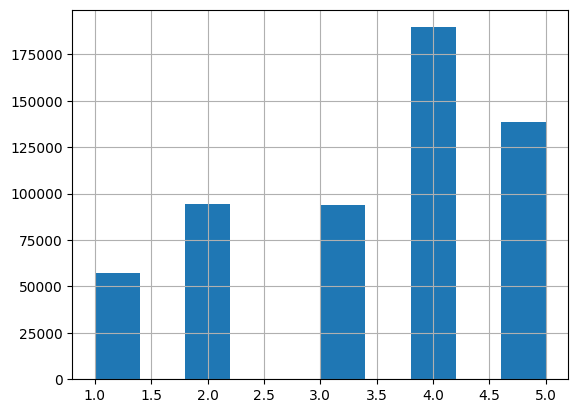

In [12]:
df_has_reviews["semantic_rating"].hist()

In [ ]:
df_final = pd.merge(
    df,
    df_has_reviews[['userId', 'movieId', 'semantic_rating']],
    on=['userId', 'movieId'],
    how='left'
)

df_final['final_rating'] = df_final['semantic_rating'].fillna(df_final['rating'])


In [20]:
df_final.to_csv("data/final_ratings_all_columns.csv", index=False)

In [21]:
df_final.drop(columns=['review_raw_rating', 'review_text', 'rating_diff', 'rating', 'semantic_rating'], inplace=True)

In [22]:
df_final

,userId,movieId,final_rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0
...,...,...,...
32000199,200948,79702,4.5
32000200,200948,79796,1.0
32000201,200948,80350,0.5
32000202,200948,80463,3.5


In [23]:
df_final.to_csv("data/final_ratings_essential_columns.csv", index=False)